##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Transfer learning with TensorFlow Hub

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning_with_hub.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning_with_hub.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/transfer_learning_with_hub.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

[TensorFlow Hub](https://tfhub.dev/) is a repository of pre-trained TensorFlow models.

This tutorial demonstrates how to:

1. Use models from TensorFlow Hub with `tf.keras`.
1. Use an image classification model from TensorFlow Hub.
1. Do simple transfer learning to fine-tune a model for your own image classes.

## Setup

In [2]:
import numpy as np
import time

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

import datetime

%load_ext tensorboard

## An ImageNet classifier

You'll start by using a classifier model pre-trained on the [ImageNet](https://en.wikipedia.org/wiki/ImageNet) benchmark dataset—no initial training required!

### Download the classifier

Select a <a href="https://arxiv.org/abs/1801.04381" class="external">MobileNetV2</a> pre-trained model [from TensorFlow Hub](https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2) and wrap it as a Keras layer with [`hub.KerasLayer`](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer). Any <a href="https://tfhub.dev/s?q=tf2&module-type=image-classification/" class="external">compatible image classifier model</a> from TensorFlow Hub will work here, including the examples provided in the drop-down below.

In [3]:
mobilenet_v2 ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
inception_v3 = "https://tfhub.dev/google/imagenet/inception_v3/classification/5"

classifier_model = mobilenet_v2 #@param ["mobilenet_v2", "inception_v3"] {type:"raw"}

In [4]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_model, input_shape=IMAGE_SHAPE+(3,)) #因為是RGB彩色所以,括號內填入3
])

### Run it on a single image

Download a single image to try the model on:

178796/178796 [==============================] - 1s 4us/step


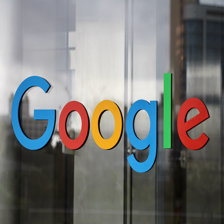

In [5]:
grace_hopper = tf.keras.utils.get_file('google.jpg','https://img.technews.tw/wp-content/uploads/2021/03/04115228/Google-Taiwan-new-campus-located-in-New-Taipei-City-25.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [6]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

Add a batch dimension (with `np.newaxis`) and pass the image to the model:

In [7]:
result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape

1/1 [==============================] - 9s 9s/step


(1, 1001)

The result is a 1001-element vector of logits, rating the probability of each class for the image.

The top class ID can be found with `tf.math.argmax`:

In [8]:
predicted_class = tf.math.argmax(result[0], axis=-1)
predicted_class

<tf.Tensor: shape=(), dtype=int64, numpy=601>

### Decode the predictions

Take the `predicted_class` ID (such as `653`) and fetch the ImageNet dataset labels to decode the predictions:

In [9]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

10484/10484 [==============================] - 0s 0us/step


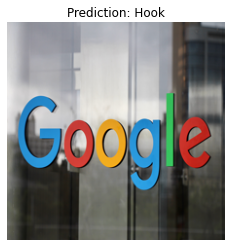

In [10]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

## Simple transfer learning

But what if you want to create a custom classifier using your own dataset that has classes that aren't included in the original ImageNet dataset (that the pre-trained model was trained on)?

To do that, you can:

1. Select a pre-trained model from TensorFlow Hub; and
2. Retrain the top (last) layer to recognize the classes from your custom dataset.

### Dataset

In this example, you will use the TensorFlow flowers dataset:

First, load this data into the model using the image data off disk with `tf.keras.utils.image_dataset_from_directory`, which will generate a `tf.data.Dataset`:

In [11]:
#drive.mount('/content/drive')

In [22]:
import os
from google.colab import drive
MOUNTPOINT = "/content/gdrive"
DATADIR = os.path.join(MOUNTPOINT, "MyDrive/Ksu_AI_111-1/Datasets_1205")
drive.mount(MOUNTPOINT)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [23]:
data_path = os.path.join(DATADIR, "fruit.zip")

In [24]:
import zipfile
with zipfile.ZipFile(data_path, 'r') as zip_ref:
    zip_ref.extractall('/content/data')

In [25]:
batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.utils.image_dataset_from_directory(
  str('/content/data/fruit'),
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  str('/content/data/fruit'),
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 100 files belonging to 5 classes.
Using 80 files for training.
Found 100 files belonging to 5 classes.
Using 20 files for validation.


The flowers dataset has five classes:

In [26]:
class_names = np.array(train_ds.class_names)
print(class_names)

['Actinidia deliciosa' 'banana' 'lemon' 'orange' 'strawberry']


Second, because TensorFlow Hub's convention for image models is to expect float inputs in the `[0, 1]` range, use the `tf.keras.layers.Rescaling` preprocessing layer to achieve this.

Note: You could also include the `tf.keras.layers.Rescaling` layer inside the model. Refer to the [Working with preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers) guide for a discussion of the tradeoffs.

In [27]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.

Third, finish the input pipeline by using buffered prefetching with `Dataset.prefetch`, so you can yield the data from disk without I/O blocking issues.

These are some of the most important `tf.data` methods you should use when loading data. Interested readers can learn more about them, as well as how to cache data to disk and other techniques, in the [Better performance with the tf.data API](https://www.tensorflow.org/guide/data_performance#prefetching) guide.

In [28]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [29]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


### Run the classifier on a batch of images

Now, run the classifier on an image batch:

In [30]:
result_batch = classifier.predict(train_ds)

3/3 [==============================] - 1s 192ms/step


In [31]:
predicted_class_names = imagenet_labels[tf.math.argmax(result_batch, axis=-1)]
predicted_class_names

array(['orange', 'acorn', 'hen-of-the-woods', 'banana', 'orange',
       'worm fence', 'lemon', 'lemon', 'strawberry', 'orange', 'ear',
       'strawberry', 'banana', 'jackfruit', 'strawberry', 'jackfruit',
       'lemon', 'lemon', 'banana', 'lemon', 'strawberry', 'eggnog',
       'magnetic compass', 'strawberry', 'strawberry', 'strawberry',
       'hen-of-the-woods', 'lemon', 'lemon', 'strawberry', 'banana',
       'banana', 'orange', 'orange', 'lemon', 'Granny Smith', 'orange',
       'banana', 'magnetic compass', 'lemon', 'orange', 'lemon', 'orange',
       'strawberry', 'banana', 'banana', 'orange', 'lemon', 'banana',
       'earthstar', 'orange', 'banana', 'strawberry', 'orange', 'banana',
       'banana', 'strawberry', 'orange', 'fig', 'spaghetti squash',
       'banana', 'earthstar', 'orange', 'banana', 'Granny Smith',
       'strawberry', 'strawberry', 'Granny Smith', 'fig',
       'spaghetti squash', 'orange', 'lemon', 'strawberry', 'lemon',
       'banana', 'honeycomb', 'Gran

Check how these predictions line up with the images:

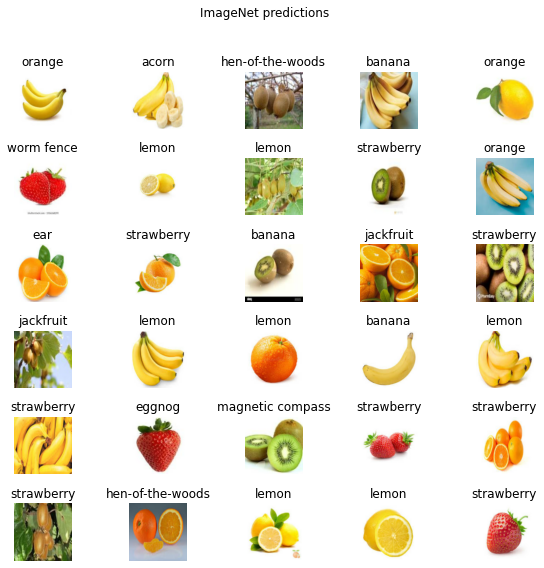

In [32]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

Note: all images are licensed CC-BY, creators are listed in the LICENSE.txt file.

The results are far from perfect, but reasonable considering that these are not the classes the model was trained for (except for "daisy").

### Download the headless model

TensorFlow Hub also distributes models without the top classification layer. These can be used to easily perform transfer learning.

Select a <a href="https://arxiv.org/abs/1801.04381" class="external">MobileNetV2</a> pre-trained model <a href="https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4" class="external">from TensorFlow Hub</a>. Any <a href="https://tfhub.dev/s?module-type=image-feature-vector&q=tf2" class="external">compatible image feature vector model</a> from TensorFlow Hub will work here, including the examples from the drop-down menu.

In [33]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
inception_v3 = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"

feature_extractor_model = mobilenet_v2 #@param ["mobilenet_v2", "inception_v3"] {type:"raw"}

Create the feature extractor by wrapping the pre-trained model as a Keras layer with [`hub.KerasLayer`](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer). Use the `trainable=False` argument to freeze the variables, so that the training only modifies the new classifier layer:

In [34]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False)

The feature extractor returns a 1280-long vector for each image (the image batch size remains at 32 in this example):

In [35]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


### Attach a classification head

To complete the model, wrap the feature extractor layer in a `tf.keras.Sequential` model and add a fully-connected layer for classification:

In [36]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [37]:
predictions = model(image_batch)

In [38]:
predictions.shape

TensorShape([32, 5])

### Train the model

Use `Model.compile` to configure the training process and add a `tf.keras.callbacks.TensorBoard` callback to create and store logs:

In [39]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1) # Enable histogram computation for every epoch.

Now use the `Model.fit` method to train the model.

To keep this example short, you'll be training for just 10 epochs. To visualize the training progress in TensorBoard later, create and store logs an a [TensorBoard callback](https://www.tensorflow.org/tensorboard/get_started#using_tensorboard_with_keras_modelfit).

In [40]:
NUM_EPOCHS = 10

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=NUM_EPOCHS,
                    callbacks=tensorboard_callback)

Epoch 1/10
3/3 [==============================] - 7s 1s/step - loss: 1.9665 - acc: 0.1375 - val_loss: 1.2997 - val_acc: 0.4500
Epoch 2/10
3/3 [==============================] - 1s 723ms/step - loss: 1.4134 - acc: 0.4000 - val_loss: 1.0241 - val_acc: 0.7000
Epoch 3/10
3/3 [==============================] - 2s 758ms/step - loss: 1.0277 - acc: 0.6625 - val_loss: 0.8018 - val_acc: 0.8500
Epoch 4/10
3/3 [==============================] - 2s 751ms/step - loss: 0.7341 - acc: 0.8000 - val_loss: 0.6356 - val_acc: 0.9500
Epoch 5/10
3/3 [==============================] - 2s 755ms/step - loss: 0.5256 - acc: 0.9250 - val_loss: 0.5227 - val_acc: 0.9500
Epoch 6/10
3/3 [==============================] - 2s 737ms/step - loss: 0.3870 - acc: 0.9625 - val_loss: 0.4470 - val_acc: 0.9500
Epoch 7/10
3/3 [==============================] - 2s 735ms/step - loss: 0.2961 - acc: 0.9750 - val_loss: 0.3940 - val_acc: 0.9500
Epoch 8/10
3/3 [==============================] - 2s 747ms/step - loss: 0.2353 - acc: 1.0000 

Start the TensorBoard to view how the metrics change with each epoch and to track other scalar values:

In [41]:
%tensorboard --logdir logs/fit

<IPython.core.display.Javascript object>

<!-- <img class="tfo-display-only-on-site" src="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/images/tensorboard_transfer_learning_with_hub.png?raw=1"/> -->

### Check the predictions

Obtain the ordered list of class names from the model predictions:

In [42]:
predicted_batch = model.predict(image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
print(predicted_label_batch)

1/1 [==============================] - 0s 444ms/step
['banana' 'banana' 'Actinidia deliciosa' 'banana' 'lemon' 'strawberry'
 'lemon' 'Actinidia deliciosa' 'Actinidia deliciosa' 'banana' 'orange'
 'orange' 'Actinidia deliciosa' 'orange' 'Actinidia deliciosa'
 'Actinidia deliciosa' 'banana' 'orange' 'banana' 'banana' 'banana'
 'strawberry' 'Actinidia deliciosa' 'strawberry' 'orange'
 'Actinidia deliciosa' 'orange' 'lemon' 'lemon' 'strawberry' 'strawberry'
 'strawberry']


Plot the model predictions:

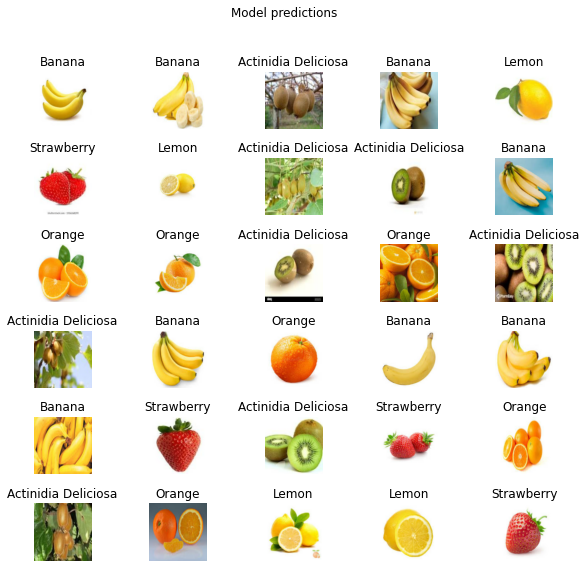

In [43]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")

## Export and reload your model

Now that you've trained the model, export it as a SavedModel for reusing it later.

In [44]:
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
model.save(export_path)

export_path

'/tmp/saved_models/1670226362'

Confirm that you can reload the SavedModel and that the model is able to output the same results:

In [45]:
reloaded = tf.keras.models.load_model(export_path)

In [46]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

1/1 [==============================] - 0s 438ms/step


In [47]:
abs(reloaded_result_batch - result_batch).max()

0.0

In [48]:
reloaded_predicted_id = tf.math.argmax(reloaded_result_batch, axis=-1)
reloaded_predicted_label_batch = class_names[reloaded_predicted_id]
print(reloaded_predicted_label_batch)

['banana' 'banana' 'Actinidia deliciosa' 'banana' 'lemon' 'strawberry'
 'lemon' 'Actinidia deliciosa' 'Actinidia deliciosa' 'banana' 'orange'
 'orange' 'Actinidia deliciosa' 'orange' 'Actinidia deliciosa'
 'Actinidia deliciosa' 'banana' 'orange' 'banana' 'banana' 'banana'
 'strawberry' 'Actinidia deliciosa' 'strawberry' 'orange'
 'Actinidia deliciosa' 'orange' 'lemon' 'lemon' 'strawberry' 'strawberry'
 'strawberry']


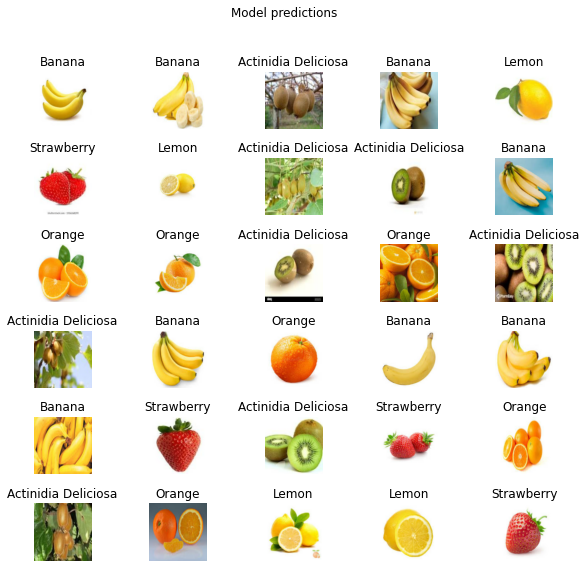

In [49]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(reloaded_predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")

## Next steps

You can use the SavedModel to load for inference or convert it to a [TensorFlow Lite](https://www.tensorflow.org/lite/models/convert/)  model (for on-device machine learning) or a [TensorFlow.js](https://www.tensorflow.org/js/tutorials#convert_pretrained_models_to_tensorflowjs) model (for machine learning in JavaScript).

Discover [more tutorials](https://www.tensorflow.org/hub/tutorials) to learn how to use pre-trained models from TensorFlow Hub on image, text, audio, and video tasks.